In [7]:
import cv2
import numpy as np

# 3D-NEAT

In [8]:
from matplotlib import pyplot as plt
def readSourceImage(filepath:str):
    iim = cv2.imread(filename=filepath)
    # OpenCV 預設 BGR
    iim = cv2.cvtColor(iim, cv2.COLOR_BGR2RGB)
    return iim
    
def saveImage(filepath: str, im: cv2.Mat):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filepath, im)
    ()

In [9]:
from pathlib import Path
# sourceImage = readSourceImage("test/r128.png")
sourceImage = readSourceImage("test/nchu_goose.jpeg")

In [10]:
(M, N, K) = sourceImage.shape
# K = K
K = K * 8
theImage = sourceImage.astype(int)
# Assume it is 3 channels
theImage = (theImage[:,:,0] << 16) | (theImage[:,:,1] << 8) | (theImage[:,:,2])

In [11]:
bx = 1
by = 1
bz = 1

rx = 1
ry = 1
rz = 1

import math
cx = rx * (K // math.gcd(N, K))
cy = ry * (M // math.gcd(K, M))
cz = rz * (N // math.gcd(M, N))

In [12]:
t1 = np.array([
    [1, bz, 0], 
    [cz, (1 + bz * cz), 0],
    [0, 0, 1]
], dtype=int)

t2 = np.array([
    [1, 0, 0],
    [0, 1, bx],
    [0, cx, (1 + bx * cx)]
], dtype=int)

t3 = np.array([
    [1 + by * cy, 0, cy],
    [0, 1, 0],
    [by, 0, 1]
], dtype=int)

In [13]:
theShape = (M, N, K)

KK = np.arange(K, dtype=int)
KK = np.tile(KK, N)

NN = np.arange(N, dtype=int)
NN = np.repeat(NN, K)

NK = np.stack((NN, KK))
MNK = np.tile(NK, M)

MM = np.arange(M, dtype=int)
MM = np.repeat(MM, N * K).reshape(1, -1)

MNK = np.concatenate((MM, MNK))

In [14]:
def doModuleDot(tt: np.array, ss: np.array):
    rr = tt.dot(ss)
    rr[0,:] = rr[0,:] % M
    rr[1,:] = rr[1, :] % N
    rr[2,:] = rr[2, :] % K
    return rr

In [15]:
sy = doModuleDot(t1, MNK)
sy = doModuleDot(t2, sy)
sy = doModuleDot(t3, sy)

In [16]:
def applyTransform(im: np.array):
    result = np.zeros((M, N), dtype=int)
    for i in range(MNK.shape[-1]):
        ss = MNK[:, i]
        tt = sy[:, i]
        bb = im[ss[0], ss[1]] & (1 << ss[2])
        bbb = 1 if bb != 0 else 0
        result[tt[0], tt[1]] |= (bbb << tt[2])
    return result

def showImage(rr: np.array):
    resultImage = np.zeros((M, N, K // 8), dtype=np.uint8)
    resultImage[:,:,0] = rr >> 16
    resultImage[:,:,1] = rr >> 8
    resultImage[:,:,2] = rr
    resultImage = resultImage.astype(np.uint8)
    plt.imshow(resultImage)
    plt.show()
    pass

In [17]:
# This will take a while.
result = applyTransform(theImage)

# INEAT

In [18]:
def getInverseMatrix():
    rr = MNK.copy()
    yx = rr[1, :]
    xx = (rr[0, :] - cy * rr[2, :]) % M
    zx = (rr[2, :] - by * xx) % K

    xz = xx
    zz = (zx - cx * yx) % K
    yz = (yx - bx * zz) % N

    zn = zz
    yn = (yz - cz * xz) % N
    xn = (xz - bz * yn) % M

    rr[0,:] = xn
    rr[1, :] = yn
    rr[2, :] = zn
    return rr

rr = getInverseMatrix()

In [19]:
def applyInverseTransform(im: np.array):
    result = np.zeros((M, N), dtype=int)
    for i in range(MNK.shape[-1]):
        ss = MNK[:, i]
        tt = rr[:, i]
        bb = im[ss[0], ss[1]] & (1 << ss[2])
        bbb = 1 if bb != 0 else 0
        result[tt[0], tt[1]] |= (bbb << tt[2])
    return result

iresult = applyInverseTransform(result)

In [20]:
# print(theImage)
# print(result)
# print(iresult)
# x = np.unpackbits(theImage.view(np.uint8)).sum()
# y = np.unpackbits(result.view(np.uint8)).sum()
# z = np.unpackbits(iresult.view(np.uint8)).sum()
# (x,y,z)

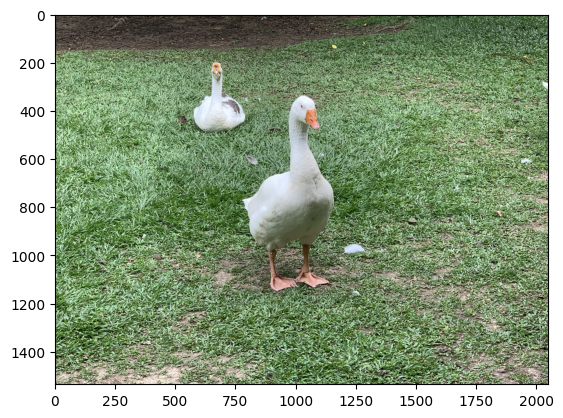

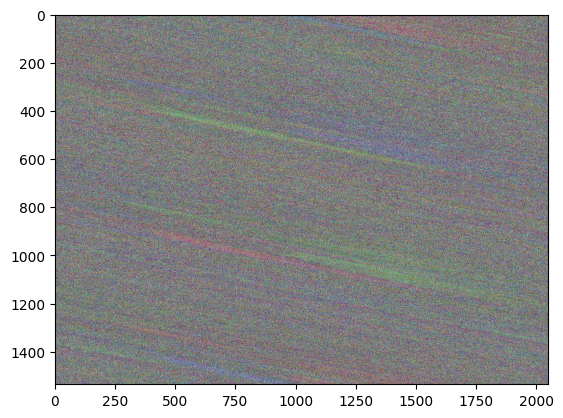

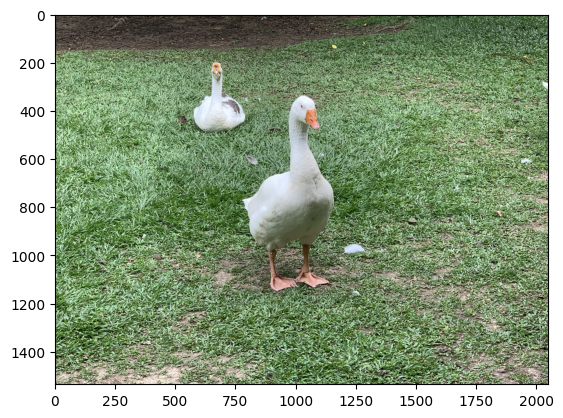

In [21]:
showImage(theImage)
showImage(result)
showImage(iresult)